In [1]:
# Jupyter Notebook

# Importando as bibliotecas necessárias
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import EcoSimpy

# Configurações iniciais
sns.set_theme(style="whitegrid")
pd.options.mode.chained_assignment = None  # Para evitar warnings de cópias de DataFrame


print("Current directory:", os.getcwd())

# Configurando os diretórios
input_dir = Path("runs")
output_dir = Path("results")
output_dir.mkdir(exist_ok=True)

/home/rivero/.venv/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Current directory: /home/rivero/Dropbox/Workspace_Current/Projects/Apps/EcoSimpy_dev/apps/ipd


## Execução da Simulação

In [2]:
def main():
    # Activate virtual environment (if needed, adjust path accordingly)
    venv_path = os.path.join(os.getcwd(), "venv")
    if os.path.exists(venv_path):
        activate_script = os.path.join(venv_path, "bin", "activate_this.py")
        with open(activate_script) as f:
            exec(f.read(), {'__file__': activate_script})


    print("Current directory:", os.getcwd())

        # Read kernel_dir from config.json
    config_json_file = "config.json"        

    # Get current directory as app_dir
    app_dir = os.getcwd()

    new_sim = EcoSimpy.Simulation(app_dir, 
                                  config_json_file, 
                                  clean_run=True)

    new_sim.execute_simulation()


if __name__ == "__main__":
    main()

Current directory: /home/rivero/Dropbox/Workspace_Current/Projects/Apps/EcoSimpy_dev/apps/ipd


Scenario: ZD_base Run nr.: 9: 100%|██████████| 5000/5000 [00:00<00:00, 26874.06it/s]


Observer data saved to ipd_GoodPlayer_obs1_2025-09-07T16_06_.csv
Observer data saved to ipd_HardTitForTatPlayer_obs1_2025-09-07T16_06_.csv
Observer data saved to ipd_ZDExtortionPlayer_obs1_2025-09-07T16_07_.csv


## Análise do Resultado

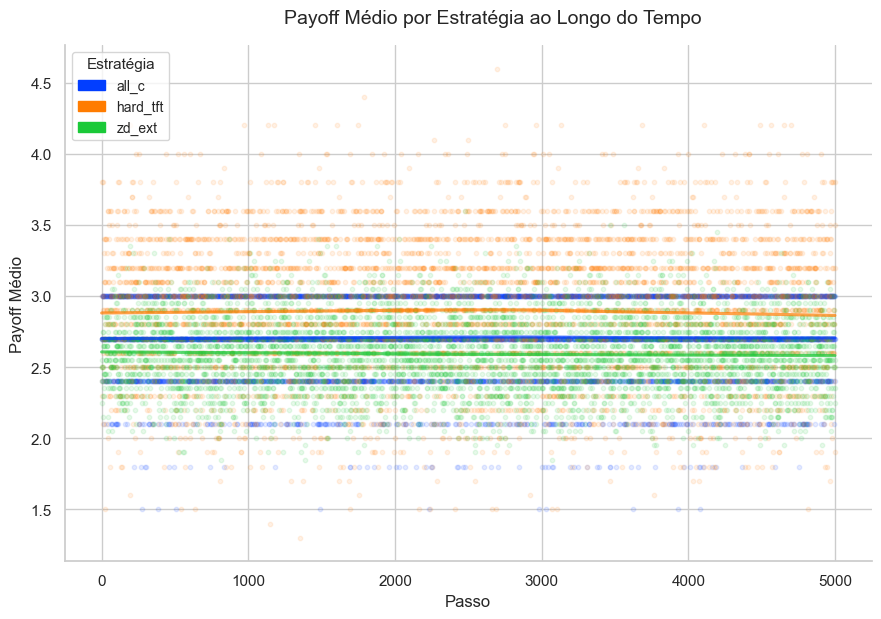

/tmp/ipykernel_129436/3323885649.py:81: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_129436/3323885649.py:81: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


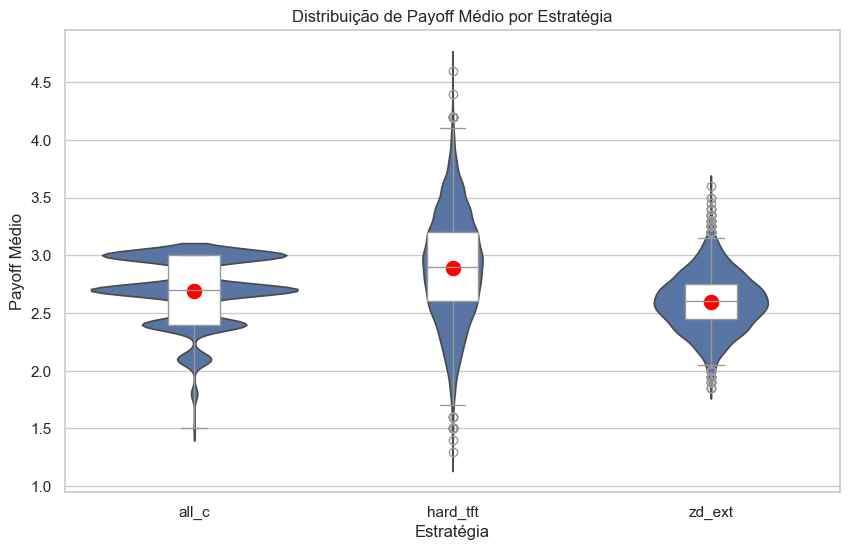

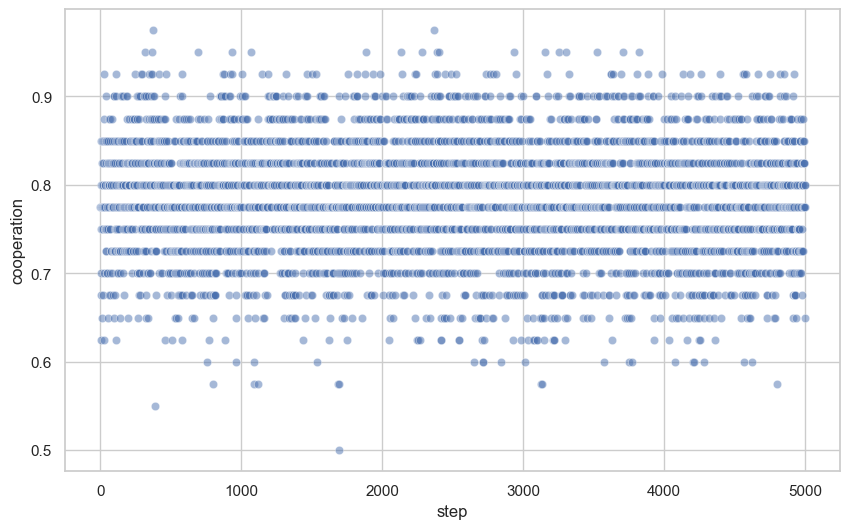

<Figure size 1000x600 with 0 Axes>

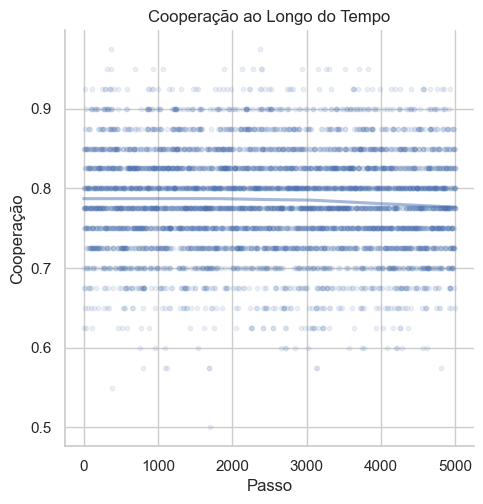

In [3]:

# Obtendo os arquivos CSV
csv_files = list(input_dir.glob("*.csv"))

# Gerando o DataFrame consolidado
runs_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
runs_df_or = runs_df.copy()
runs_df = runs_df.dropna()

# Calculando a diferença de payoffs
runs_df["diff_payoffs"] = runs_df["my_payoff"] - runs_df["other_payoff"]

# Agrupando os dados para calcular médias e somas de payoffs
sum_runs = (
    runs_df.groupby(["scenario", "step", "strategy_name"])
    .agg(
        payoff_mean=("my_payoff", "mean"),
        payoff_sum=("my_payoff", "sum"),
    )
    .reset_index()
)

# Calculando cooperação e defecção
sum_cooperation = (
    runs_df.groupby(["scenario", "step"])
    .agg(
        my_play_C=("my_play", lambda x: (x == "C").sum()),
        my_play_D=("my_play", lambda x: (x == "D").sum()),
        ot_play_C=("other_play", lambda x: (x == "C").sum()),
        ot_play_D=("other_play", lambda x: (x == "D").sum()),
        players=("my_play", "count"),
    )
    .reset_index()
)

sum_cooperation["cooperation"] = sum_cooperation["my_play_C"] / sum_cooperation["players"]
sum_cooperation["defection"] = sum_cooperation["my_play_D"] / sum_cooperation["players"]


from matplotlib.patches import Patch

# Gera uma paleta mais saturada
unique_strategies = sum_runs["strategy_name"].unique()
palette = sns.color_palette("bright", n_colors=len(unique_strategies))

# Cria um mapeamento de cores
color_dict = dict(zip(unique_strategies, palette))

# Recria o lmplot com a paleta
g = sns.lmplot(
    data=sum_runs, 
    x="step", 
    y="payoff_mean",
    hue="strategy_name",
    palette=color_dict,
    scatter=True, 
    lowess=True, 
    line_kws={"alpha": 0.7},
    scatter_kws={"alpha": 0.1, "s": 10},
    height=6, aspect=1.5
)

# Títulos e eixos
g.set_axis_labels("Passo", "Payoff Médio")
g.fig.suptitle("Payoff Médio por Estratégia ao Longo do Tempo", fontsize=14, y=1.03)

# Remove a legenda original
g._legend.remove()

# Cria legenda personalizada com patches coloridos e mais saturados
handles = [Patch(color=color_dict[strategy], label=strategy) for strategy in unique_strategies]
g.ax.legend(handles=handles, title="Estratégia", fontsize=10, title_fontsize=11)

# Salvar e mostrar
plt.savefig(output_dir / "payoff_mean_by_strategy.png", bbox_inches="tight")
plt.show()

# Gráfico 2: Distribuição de payoff médio por estratégia
plt.figure(figsize=(10, 6))
sns.violinplot(data=sum_runs, x="strategy_name", y="payoff_mean", inner=None)
sns.boxplot(data=sum_runs, x="strategy_name", y="payoff_mean", width=0.2, color="white")
sns.pointplot(
    data=sum_runs,
    x="strategy_name",
    y="payoff_mean",
    color="red",
    join=False,
    markers="o",
    scale=1.5,
)
plt.title("Distribuição de Payoff Médio por Estratégia")
plt.xlabel("Estratégia")
plt.ylabel("Payoff Médio")
plt.savefig(output_dir / "payoff_distribution_by_strategy.png")
plt.show()

# Gráfico 3: Cooperação ao longo do tempo
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sum_cooperation, 
                x="step", 
                y="cooperation", 
                alpha=0.5
                )

plt.figure(figsize=(10, 6))
sns.lmplot(data=sum_cooperation, 
           x="step", 
           y="cooperation", 
           scatter=True, 
            lowess=True, 
            line_kws={"alpha": 0.5},
            scatter_kws={"alpha": 0.1, "s": 10}
            )

plt.title("Cooperação ao Longo do Tempo")
plt.xlabel("Passo")
plt.ylabel("Cooperação")
plt.savefig(output_dir / "cooperation_over_time.png")
plt.show()

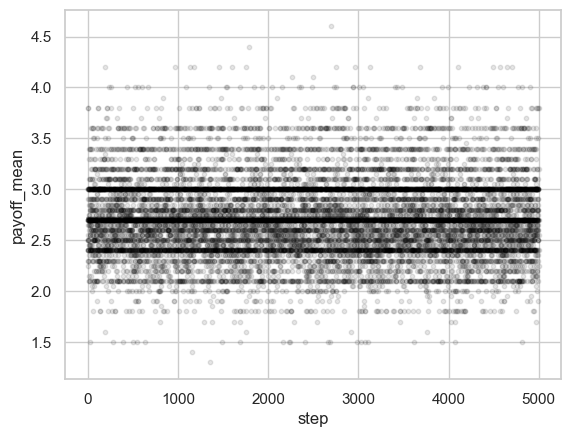

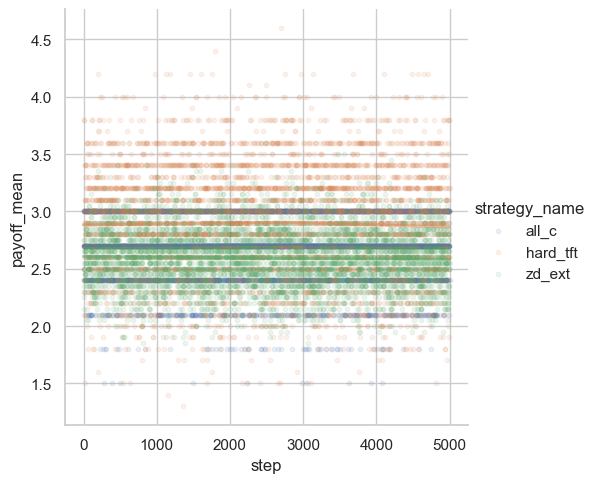

In [4]:
sns.regplot(data=sum_runs, 
            x="step", 
            y="payoff_mean",
            label="strategy_name",
            scatter=True, 
            lowess=True, 
            color="black", 
            line_kws={"alpha": 0.5},
            scatter_kws={"alpha": 0.1, "s": 10})


sns.lmplot(data=sum_runs, 
            x="step", 
            y="payoff_mean",
            hue="strategy_name",
            scatter=True, 
            lowess=True, 
            line_kws={"alpha": 0.5},
            scatter_kws={"alpha": 0.1, "s": 10})
